D:\Software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\CJY\AppData\Local\Temp\ipykernel_7424\3819574149.py:59: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
D:\Software\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


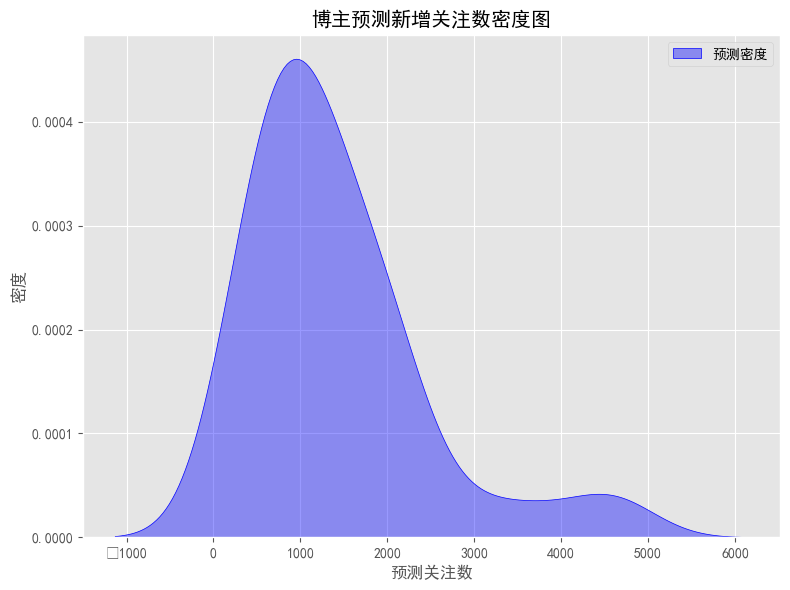

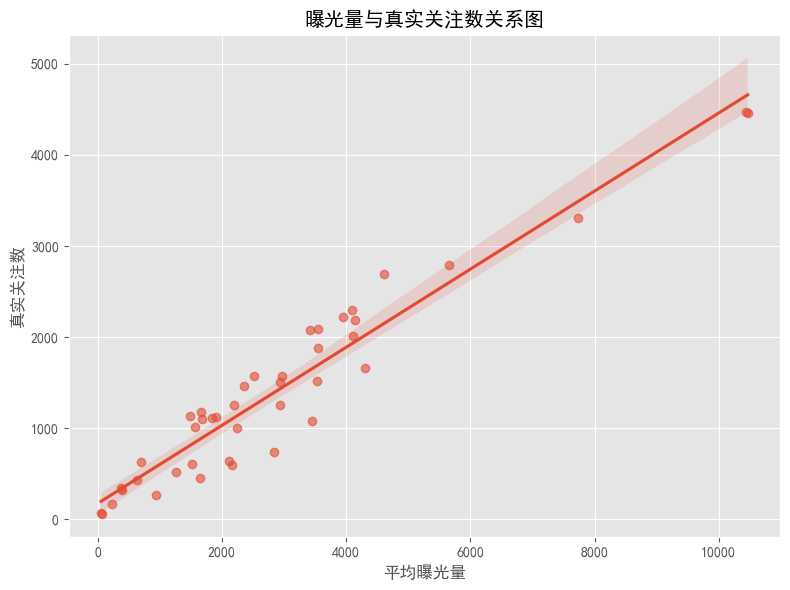

D:\Software\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


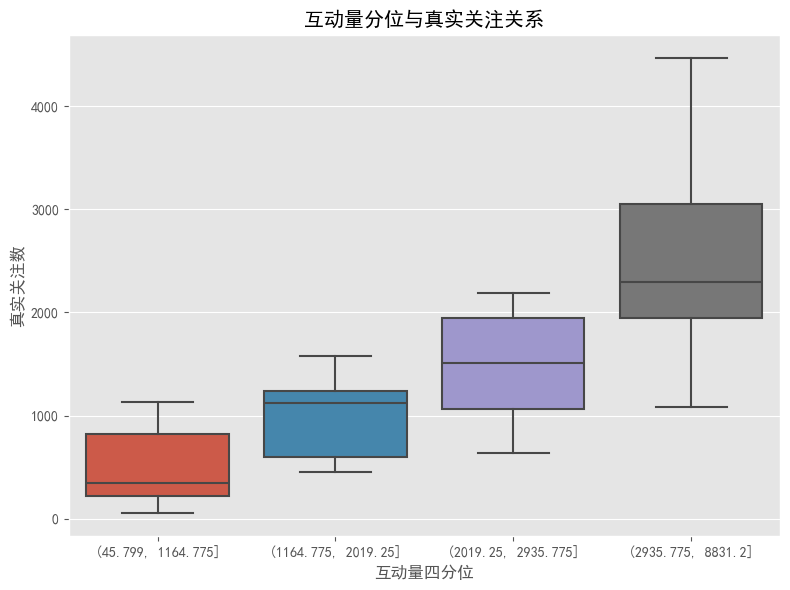

<Figure size 800x600 with 0 Axes>

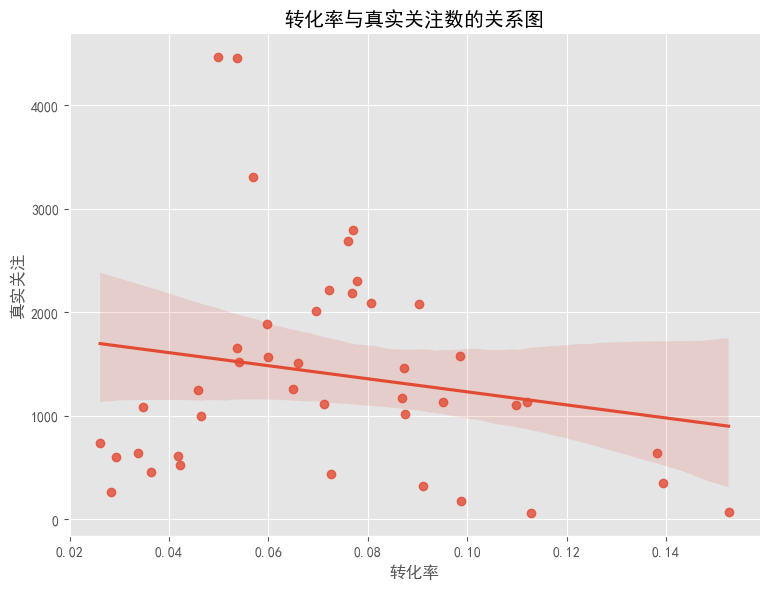

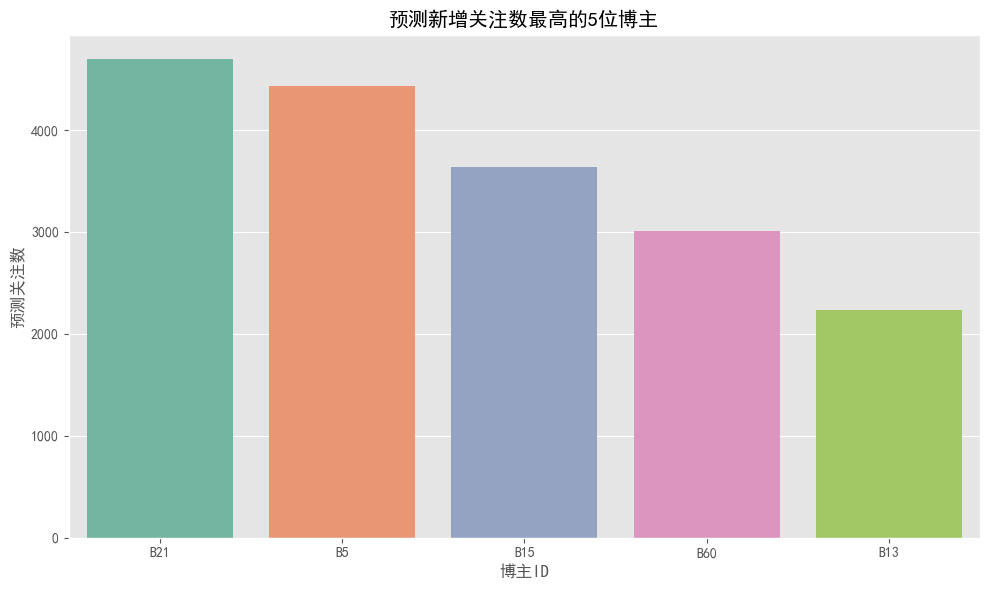

action_name creator_id         预测关注
10                 B21  4698.854178
27                  B5  4430.522256
3                  B15  3640.641827
33                 B60  3006.258407
2                  B13  2238.184689


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('ggplot')

# 读取数据
data = pd.read_csv("附件1 (Attachment 1).csv")
data.columns = ['user_id', 'action_type', 'creator_id', 'timestamp']
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 映射行为
action_dict = {1: '浏览', 2: '点赞', 3: '评论', 4: '关注'}
data['action_name'] = data['action_type'].map(action_dict)
data['date'] = data['timestamp'].dt.date

# 构建行为统计透视表
daily_summary = data.pivot_table(index=['creator_id', 'date'], columns='action_name', 
                                 aggfunc='size', fill_value=0).reset_index()

for action in ['浏览', '点赞', '评论', '关注']:
    if action not in daily_summary.columns:
        daily_summary[action] = 0

# 构造指标特征
daily_summary['曝光量'] = daily_summary['浏览']
daily_summary['互动量'] = daily_summary['点赞'] + daily_summary['评论']
daily_summary['转化率'] = daily_summary['关注'] / (daily_summary['互动量'] + 1)

# 聚合到博主层级
creator_stats = daily_summary.groupby('creator_id').agg({
    '曝光量': 'mean',
    '互动量': 'mean',
    '转化率': 'mean',
    '关注': 'sum'
}).rename(columns={'关注': '真实关注'}).reset_index()

# 建模预测关注数
X = creator_stats[['曝光量', '互动量', '转化率']]
y = creator_stats['真实关注']
reg = LinearRegression().fit(X, y)
creator_stats['预测关注'] = reg.predict(X)

# Top5预测博主
top5_creators = creator_stats.sort_values(by='预测关注', ascending=False).head(5)

# ======= 可视化部分 =======

# 图1：预测值分布直方图 + 核密度
plt.figure(figsize=(8, 6))
sns.kdeplot(creator_stats['预测关注'], fill=True, color='blue', alpha=0.4, label='预测密度')
plt.title('博主预测新增关注数密度图')
plt.xlabel('预测关注数')
plt.ylabel('密度')
plt.legend()
plt.tight_layout()
plt.show()

# 图2：曝光量 vs 真实关注（加回归线）
plt.figure(figsize=(8, 6))
sns.regplot(data=creator_stats, x='曝光量', y='真实关注', scatter_kws={"alpha": 0.6})
plt.title('曝光量与真实关注数关系图')
plt.xlabel('平均曝光量')
plt.ylabel('真实关注数')
plt.tight_layout()
plt.show()

# 图3：互动量与真实关注的箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(x=pd.qcut(creator_stats['互动量'], 4), y=creator_stats['真实关注'])
plt.title('互动量分位与真实关注关系')
plt.xlabel('互动量四分位')
plt.ylabel('真实关注数')
plt.tight_layout()
plt.show()

# 图4：转化率 vs 真实关注（散点 + 拟合线）
plt.figure(figsize=(8, 6))
sns.lmplot(data=creator_stats, x='转化率', y='真实关注', height=6, aspect=1.3)
plt.title('转化率与真实关注数的关系图')
plt.tight_layout()
plt.show()

# 图5：Top5博主预测值条形图
plt.figure(figsize=(10, 6))
sns.barplot(data=top5_creators, x='creator_id', y='预测关注', palette='Set2')
plt.title('预测新增关注数最高的5位博主')
plt.xlabel('博主ID')
plt.ylabel('预测关注数')
plt.tight_layout()
plt.show()

# 输出结果表格
print(top5_creators[['creator_id', '预测关注']])


D:\Software\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\Software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


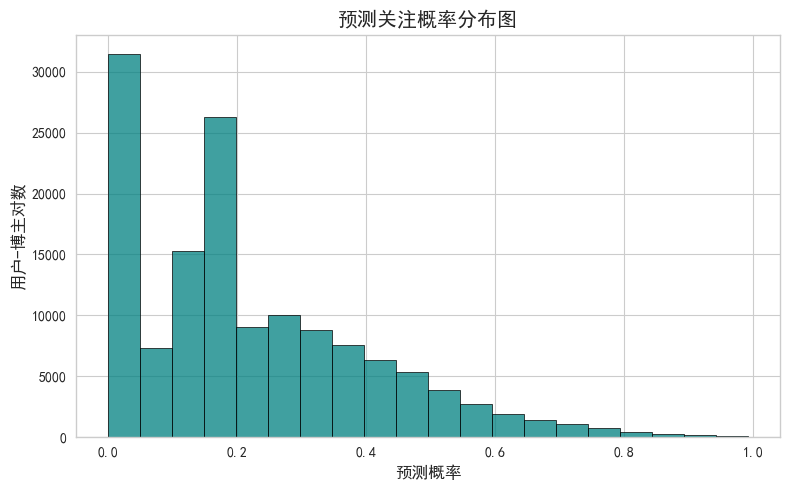

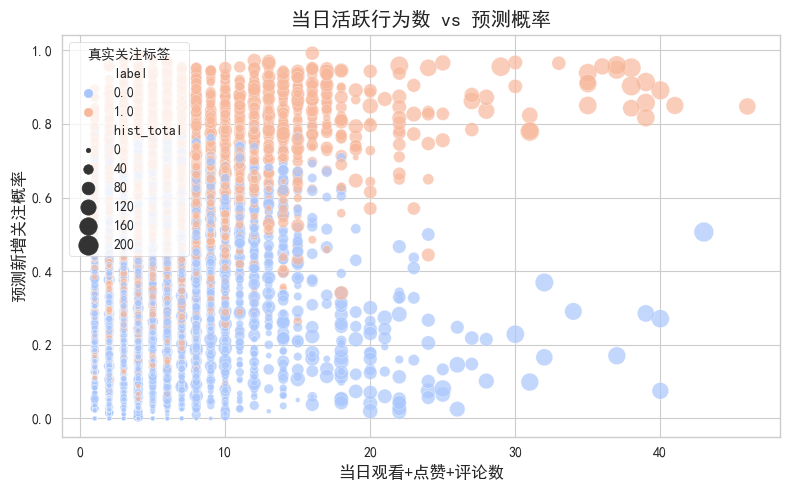

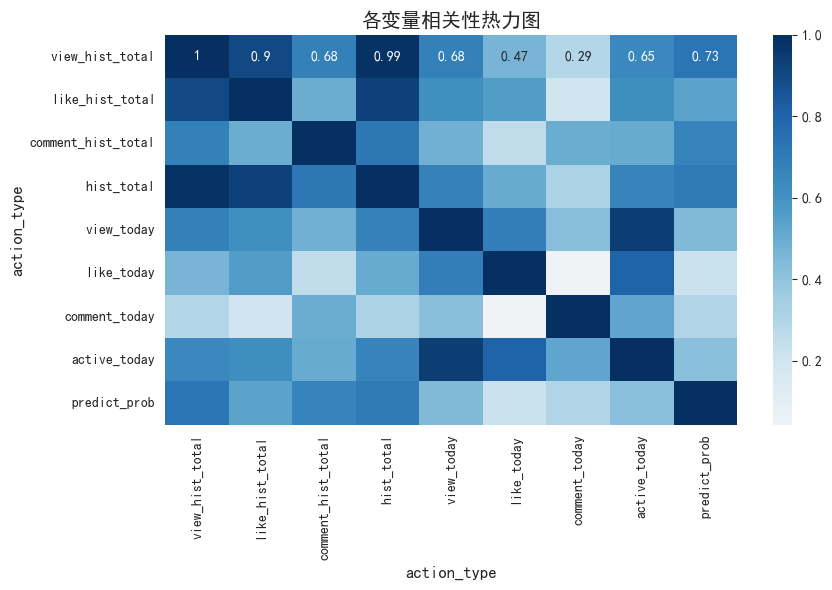

      用户ID    U7  U6749 U5769 U14990 U52010
0  新关注博主ID  [B6]  [B17]    []     []  [B13]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

plt.rcParams['font.sans-serif'] = ['SimHei']
sns.set_style('whitegrid')

# 一、读取与处理数据
df_hist = pd.read_csv("附件1 (Attachment 1).csv")
df_hist.columns = ['user_id', 'action_code', 'creator_id', 'timestamp']
df_hist['timestamp'] = pd.to_datetime(df_hist['timestamp'])
action_dict = {1: 'view', 2: 'like', 3: 'comment', 4: 'follow'}
df_hist['action_type'] = df_hist['action_code'].map(action_dict)

df_today = pd.read_csv("附件2 (Attachment 2).csv")
df_today.columns = ['user_id', 'action_code', 'creator_id', 'timestamp']
df_today['timestamp'] = pd.to_datetime(df_today['timestamp'])
df_today['action_type'] = df_today['action_code'].map({1: 'view', 2: 'like', 3: 'comment'})

# 二、构建历史训练特征
hist = df_hist.groupby(['user_id', 'creator_id', 'action_type']).size().unstack(fill_value=0).reset_index()
hist['view_hist_total'] = hist.get('view', 0)
hist['like_hist_total'] = hist.get('like', 0)
hist['comment_hist_total'] = hist.get('comment', 0)
hist['hist_total'] = hist['view_hist_total'] + hist['like_hist_total'] + hist['comment_hist_total']
hist['label'] = (hist.get('follow', 0) > 0).astype(int)

# 三、构建当前预测特征
today = df_today.groupby(['user_id', 'creator_id', 'action_type']).size().unstack(fill_value=0).reset_index()
today['view_today'] = today.get('view', 0)
today['like_today'] = today.get('like', 0)
today['comment_today'] = today.get('comment', 0)
today['active_today'] = today['view_today'] + today['like_today'] + today['comment_today']

# 四、合并特征
X = pd.merge(today, hist, on=['user_id', 'creator_id'], how='left')
X.fillna({'view_hist_total': 0, 'like_hist_total': 0, 'comment_hist_total': 0, 'hist_total': 0, 'label': 0}, inplace=True)

features = ['view_hist_total', 'like_hist_total', 'comment_hist_total', 'hist_total',
            'view_today', 'like_today', 'comment_today', 'active_today']

# 五、模型训练与预测
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X[features], X['label'])
X['predict_prob'] = model.predict_proba(X[features])[:, 1]
X['predict_label'] = (X['predict_prob'] > 0.5).astype(int)

# 六、提取目标用户预测结果
target_ids = ['U7', 'U6749', 'U5769', 'U14990', 'U52010']
result = X[(X['user_id'].isin(target_ids)) & (X['predict_label'] == 1)] \
    .groupby('user_id')['creator_id'].apply(list).reset_index()

# 若无记录则补空
for uid in target_ids:
    if uid not in result['user_id'].values:
        result = pd.concat([result, pd.DataFrame({'user_id': [uid], 'creator_id': [[]]})], ignore_index=True)

result.columns = ['用户ID', '新关注博主ID']

# 七、可视化分析图
plt.rcParams['font.sans-serif'] = ['SimHei']
# 图1：概率分布 - 条形图
plt.figure(figsize=(8, 5))
sns.histplot(X['predict_prob'], bins=20, color='teal', edgecolor='black')
plt.title('预测关注概率分布图')
plt.xlabel('预测概率')
plt.ylabel('用户-博主对数')
plt.tight_layout()
plt.savefig("图1_概率分布新.png")
plt.show()

# 图2：当日行为数 vs 概率（大小表示历史总活跃）
plt.figure(figsize=(8, 5))
sns.scatterplot(data=X, x='active_today', y='predict_prob',
                size='hist_total', sizes=(10, 200), hue='label', palette='coolwarm', alpha=0.7)
plt.title('当日活跃行为数 vs 预测概率')
plt.xlabel('当日观看+点赞+评论数')
plt.ylabel('预测新增关注概率')
plt.legend(title='真实关注标签', loc='upper left')
plt.tight_layout()
plt.savefig("图2_活跃行为预测新.png")
plt.show()

# 图3：相关性热力图（使用不同色带）
plt.figure(figsize=(9, 6))
sns.heatmap(X[features + ['predict_prob']].corr(), annot=True, cmap='RdBu', center=0)
plt.title('各变量相关性热力图')
plt.tight_layout()
plt.savefig("图3_相关性热力图新.png")
plt.show()


# 八、横向输出表2
row = {'用户ID': '新关注博主ID'}
for uid in target_ids:
    ids = result[result['用户ID'] == uid]['新关注博主ID'].values[0]
    row[uid] = ids
table2_output = pd.DataFrame([row])
print(table2_output)


D:\Software\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


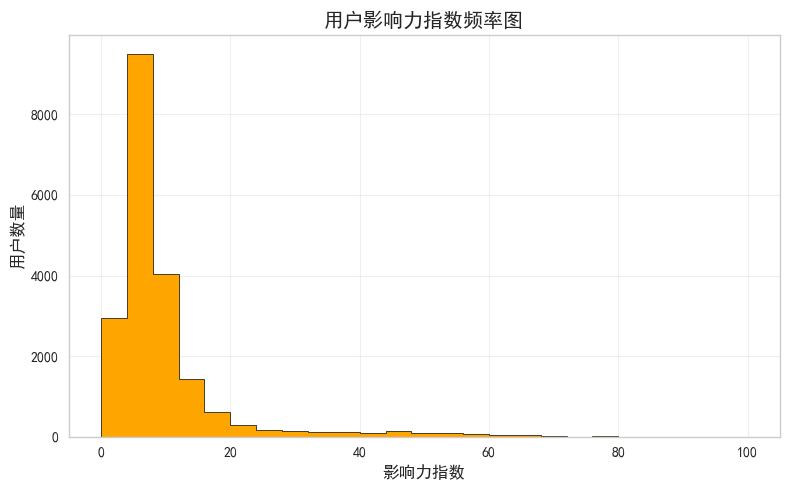

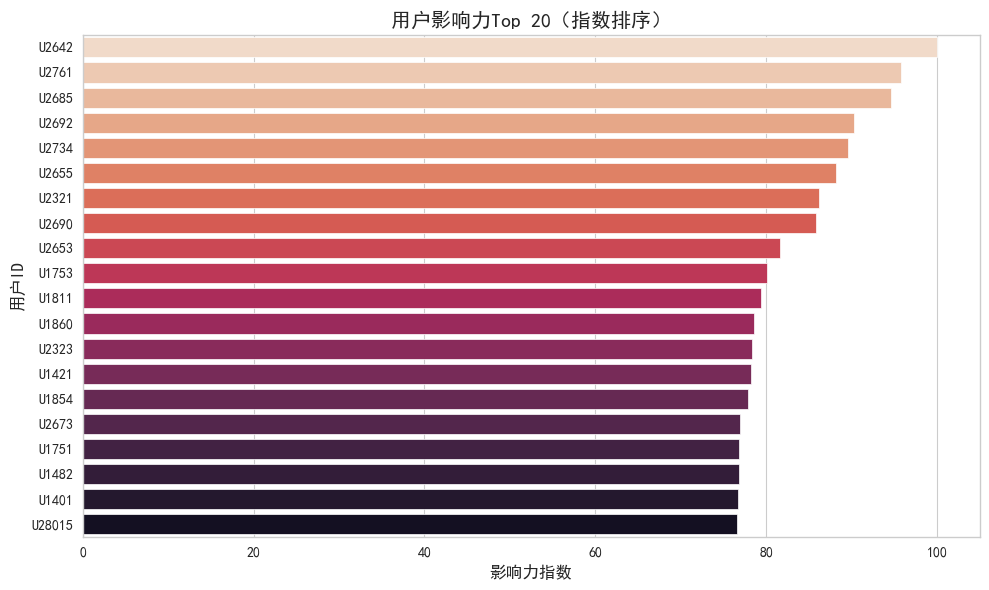

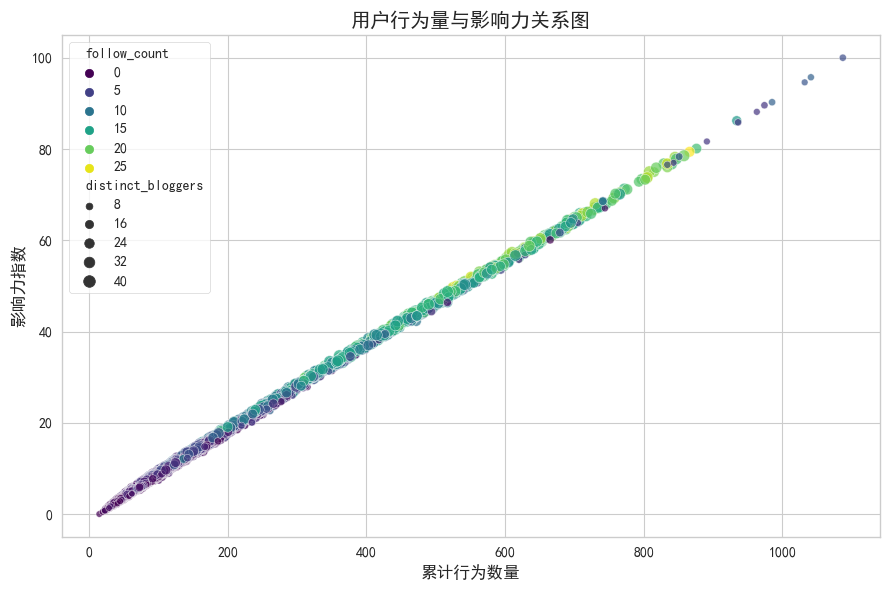

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 一、读取并构建用户特征
file_path = "附件1 (Attachment 1).csv"
chunksize = 100_000
target_date = pd.to_datetime("2024-07-21").date()
user_dict = {}

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    chunk.columns = ['user_id', 'action_type', 'creator_id', 'timestamp']
    chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], errors='coerce')
    chunk['on_target_day'] = chunk['timestamp'].dt.date == target_date

    for row in chunk.itertuples():
        uid = row.user_id
        if uid not in user_dict:
            user_dict[uid] = {
                'view_count': 0, 'like_count': 0, 'comment_count': 0, 'follow_count': 0,
                'active_dates': set(), 'creator_set': set(), 'label': 0
            }
        if row.action_type == 1:
            user_dict[uid]['view_count'] += 1
        elif row.action_type == 2:
            user_dict[uid]['like_count'] += 1
        elif row.action_type == 3:
            user_dict[uid]['comment_count'] += 1
        elif row.action_type == 4:
            user_dict[uid]['follow_count'] += 1

        user_dict[uid]['active_dates'].add(row.timestamp.date())
        user_dict[uid]['creator_set'].add(row.creator_id)

        if row.on_target_day and row.action_type in [2, 3, 4]:
            user_dict[uid]['label'] = 1

# 二、整理特征表
user_records = []
for uid, info in user_dict.items():
    user_records.append({
        'user_id': uid,
        'view_count': info['view_count'],
        'like_count': info['like_count'],
        'comment_count': info['comment_count'],
        'follow_count': info['follow_count'],
        'total_behavior': info['view_count'] + info['like_count'] + info['comment_count'] + info['follow_count'],
        'active_days_count': len(info['active_dates']),
        'distinct_bloggers': len(info['creator_set']),
        'label': info['label']
    })

user_df = pd.DataFrame(user_records)

# 三、模型训练与上线预测
features = ['view_count', 'like_count', 'comment_count', 'follow_count',
            'total_behavior', 'active_days_count', 'distinct_bloggers']
X = user_df[features]
y = user_df['label']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

# 四、预测指定用户是否上线
target_users = ['U9', 'U22405', 'U16', 'U48420']
target_df = user_df[user_df['user_id'].isin(target_users)].copy()
target_df['pred'] = clf.predict(scaler.transform(target_df[features]))

# 五、提取当日互动行为用于推荐
selected_logs = []
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    chunk.columns = ['user_id', 'action_type', 'creator_id', 'timestamp']
    chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], errors='coerce')
    chunk = chunk[
        (chunk['user_id'].isin(target_users)) &
        (chunk['timestamp'].dt.date == target_date) &
        (chunk['action_type'].isin([2, 3, 4]))
    ]
    if not chunk.empty:
        selected_logs.append(chunk)

df_online = pd.concat(selected_logs, ignore_index=True) if selected_logs else pd.DataFrame(columns=['user_id', 'creator_id'])

# 六、构建表3输出
table3_result = {'用户ID': [], '博主ID 1': [], '博主ID 2': [], '博主ID 3': []}
for uid in target_users:
    online_flag = int(target_df[target_df['user_id'] == uid]['pred'].values[0])
    if online_flag == 0:
        table3_result['用户ID'].append(uid)
        table3_result['博主ID 1'].append('')
        table3_result['博主ID 2'].append('')
        table3_result['博主ID 3'].append('')
    else:
        u_data = df_online[df_online['user_id'] == uid]
        top_creators = u_data.groupby('creator_id').size().sort_values(ascending=False).head(3).index.tolist()
        top_creators += [''] * (3 - len(top_creators))
        table3_result['用户ID'].append(uid)
        table3_result['博主ID 1'].append(top_creators[0])
        table3_result['博主ID 2'].append(top_creators[1])
        table3_result['博主ID 3'].append(top_creators[2])

df_table3 = pd.DataFrame(table3_result)


# 七、计算影响力指数
weights = {
    'view_count': 0.05, 'like_count': 0.15, 'comment_count': 0.15, 'follow_count': 0.2,
    'total_behavior': 0.15, 'active_days_count': 0.15, 'distinct_bloggers': 0.15
}
user_df['influence_score'] = sum(user_df[k] * w for k, w in weights.items())
user_df['influence_index'] = 100 * (user_df['influence_score'] - user_df['influence_score'].min()) / \
                                       (user_df['influence_score'].max() - user_df['influence_score'].min())

# 八、可视化部分
# 图1：影响力指数频率图
plt.figure(figsize=(8, 5))
plt.hist(user_df['influence_index'], bins=25, color='orange', edgecolor='black', histtype='stepfilled')
plt.title("用户影响力指数频率图")
plt.xlabel("影响力指数")
plt.ylabel("用户数量")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 图2：影响力Top 20 用户
top_users = user_df.nlargest(20, 'influence_index')
plt.figure(figsize=(10, 6))
sns.barplot(data=top_users, y='user_id', x='influence_index', palette='rocket_r')
plt.title("用户影响力Top 20（指数排序）")
plt.xlabel("影响力指数")
plt.ylabel("用户ID")
plt.tight_layout()
plt.show()

# 图3：总行为 vs 影响力指数
plt.figure(figsize=(9, 6))
sns.scatterplot(data=user_df, x='total_behavior', y='influence_index',
                size='distinct_bloggers', hue='follow_count', palette='viridis', alpha=0.7)
plt.title("用户行为量与影响力关系图")
plt.xlabel("累计行为数量")
plt.ylabel("影响力指数")
plt.grid(True)
plt.tight_layout()
plt.show()


D:\Software\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  user_id creator_1      slot_1 creator_2      slot_2 creator_3      slot_3
0     U10        B2  Late Night        B2     Evening       B27     Evening
1   U1951       B12  Late Night       B45  Late Night        B7  Late Night
2   U1833       B15     Evening       B20     Evening       B12  Late Night
3  U26447       B59     Evening       B52     Evening       B43     Evening


C:\Users\CJY\AppData\Local\Temp\ipykernel_7424\1417800828.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top3 = subset.groupby(['creator_id', 'time_slot']).size().reset_index(name='interact_count')
C:\Users\CJY\AppData\Local\Temp\ipykernel_7424\1417800828.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top3 = subset.groupby(['creator_id', 'time_slot']).size().reset_index(name='interact_count')
C:\Users\CJY\AppData\Local\Temp\ipykernel_7424\1417800828.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

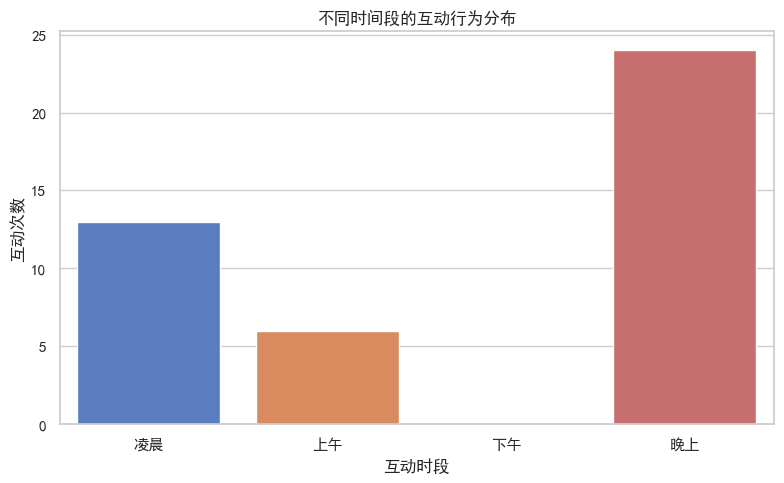

D:\Software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


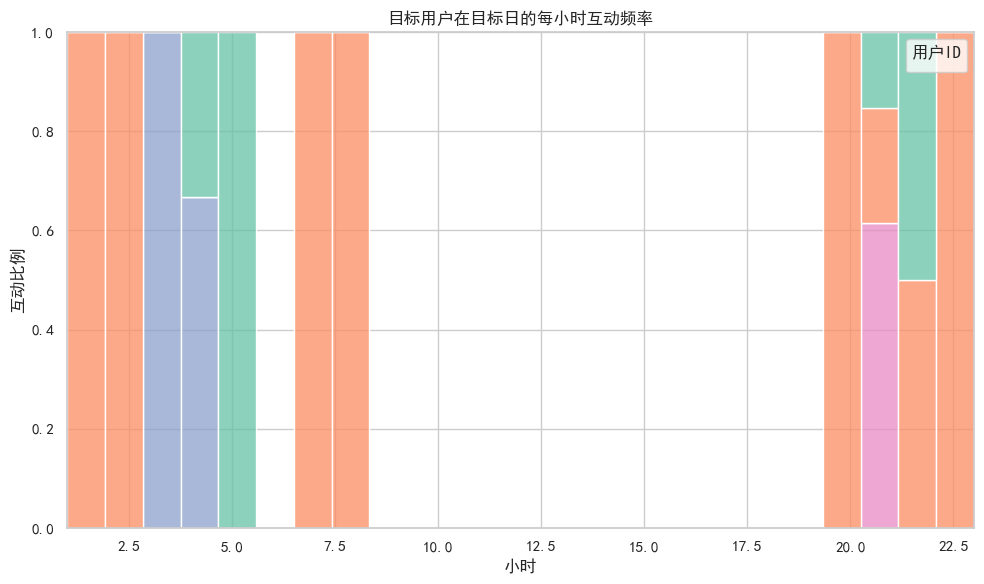

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# ---------- 1. 读取与预处理 ----------
data = pd.read_csv("附件1 (Attachment 1).csv")
data.columns = ['user_id', 'action_type', 'creator_id', 'timestamp']
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data.dropna(subset=['timestamp'], inplace=True)
data['date'] = data['timestamp'].dt.date
data['hour'] = data['timestamp'].dt.hour
data['time_slot'] = pd.cut(data['hour'], bins=[0, 6, 12, 18, 24],
                          labels=['Late Night', 'Morning', 'Afternoon', 'Evening'], right=False)

# ---------- 2. 构建用户行为特征 ----------
user_feat = data.groupby('user_id').agg({
    'action_type': 'count',
    'creator_id': pd.Series.nunique,
    'date': pd.Series.nunique
}).reset_index()
user_feat.columns = ['user_id', 'total_actions', 'unique_creators', 'active_days']

# ---------- 3. 设置目标日标签 ----------
target_date = pd.to_datetime("2024-07-12").date()
data['on_target_day'] = (data['date'] == target_date)
online_user_ids = data[data['on_target_day']]['user_id'].unique()
user_feat['label'] = user_feat['user_id'].isin(online_user_ids).astype(int)

# ---------- 4. 模型训练 ----------
feature_cols = ['total_actions', 'unique_creators', 'active_days']
scaler = MinMaxScaler()
X = scaler.fit_transform(user_feat[feature_cols])
y = user_feat['label']
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X, y)

# ---------- 5. 目标用户预测 ----------
target_ids = ['U10', 'U1951', 'U1833', 'U26447']
target_users = user_feat[user_feat['user_id'].isin(target_ids)].copy()
target_users['predicted'] = clf.predict(scaler.transform(target_users[feature_cols]))

# ---------- 6. 生成推荐表格 ----------
relevant_logs = data[
    (data['user_id'].isin(target_ids)) &
    (data['date'] == target_date) &
    (data['action_type'].isin([2, 3, 4]))
]

rec_result = {'user_id': [], 'creator_1': [], 'slot_1': [], 'creator_2': [], 'slot_2': [], 'creator_3': [], 'slot_3': []}
for uid in target_ids:
    if uid in target_users[target_users['predicted'] == 1]['user_id'].values:
        subset = relevant_logs[relevant_logs['user_id'] == uid]
        top3 = subset.groupby(['creator_id', 'time_slot']).size().reset_index(name='interact_count')
        top3 = top3.sort_values(by='interact_count', ascending=False).head(3)
        top_entries = top3[['creator_id', 'time_slot']].values.tolist()
        while len(top_entries) < 3:
            top_entries.append(['', ''])
        rec_result['user_id'].append(uid)
        for i in range(3):
            rec_result[f'creator_{i+1}'].append(top_entries[i][0])
            rec_result[f'slot_{i+1}'].append(top_entries[i][1])
    else:
        rec_result['user_id'].append(uid)
        for i in range(1, 4):
            rec_result[f'creator_{i}'].append('')
            rec_result[f'slot_{i}'].append('')

df_recommend_table = pd.DataFrame(rec_result)
print(df_recommend_table)

# ---------- 7. 可视化 ----------
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

# 图1：互动行为时段分布（中文）
plt.figure(figsize=(8, 5))
order = ['Late Night', 'Morning', 'Afternoon', 'Evening']
order_zh = ['凌晨', '上午', '下午', '晚上']
time_slot_map = dict(zip(order, order_zh))
relevant_logs['时段中文'] = relevant_logs['time_slot'].map(time_slot_map)

sns.barplot(x='时段中文', y='action_type', data=relevant_logs.assign(action_type=1),
            estimator=sum, ci=None, order=order_zh, palette='muted')
plt.title("不同时间段的互动行为分布")
plt.xlabel("互动时段")
plt.ylabel("互动次数")
plt.tight_layout()
plt.show()

# 图2：目标用户每小时互动分布图（中文图例）
plt.figure(figsize=(10, 6))
sns.histplot(data=relevant_logs, x='hour', hue='user_id', bins=24,
             multiple='fill', palette='Set2')
plt.title("目标用户在目标日的每小时互动频率")
plt.xlabel("小时")
plt.ylabel("互动比例")
plt.legend(title="用户ID", title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()
